# Lab 11

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

## Imports

In [1]:
from math import ceil
from typing import List, Tuple

import matplotlib.pyplot as plt
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import nn, Tensor
from torch.distributions import Normal
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchsummary import summary

set_matplotlib_formats('png', 'pdf')

# Exercise 1

In this exercise, we will implement a denoising autoencoder (DAE). We will use the MNIST dataset for this task. The autoencoder will be trained on noisy images and should be able to remove the noise from the images.

In [2]:
train_x = MNIST(root='.data', download=True, transform=ToTensor())

Let's first construct a basic fully connected autoencoder.

In [33]:

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
# TODO: define self.encoder and self.decoder as fully connected neural networks with 2 hidden layers of 128 and 64 neurons respectively
# The encoder should take an input of size a flattened 28x28 image.
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # we don't want to reduce output neurons to 0
        )

    def forward(self, x):
# TODO: implement the forward pass of the autoencoder
        z = self.encoder(x)
        x = self.decoder(z)
        return x

Let's define the denoising autoencoder class which will add Gaussian noise to the input images before passing them through the autoencoder.

In [34]:

class DAE(nn.Module):
    def __init__(self, autoencoder):
        super(DAE, self).__init__()
        self.autoencoder = autoencoder

    def forward(self, x, noise_factor=0.5):
# TODO: implement the forward pass of the denoising autoencoder
# Add Gaussian noise to the input x (torch.randn_like() might be useful) and scale the noise by noise_factor
# Then pass the noisy input through the autoencoder and return the reconstructed image
        x_noisy = x + noise_factor * torch.rand_like(x)
        x_recon = self.autoencoder(x_noisy)
        return x_recon

First let's look at some original images and their noisy versions with varying noise factors.

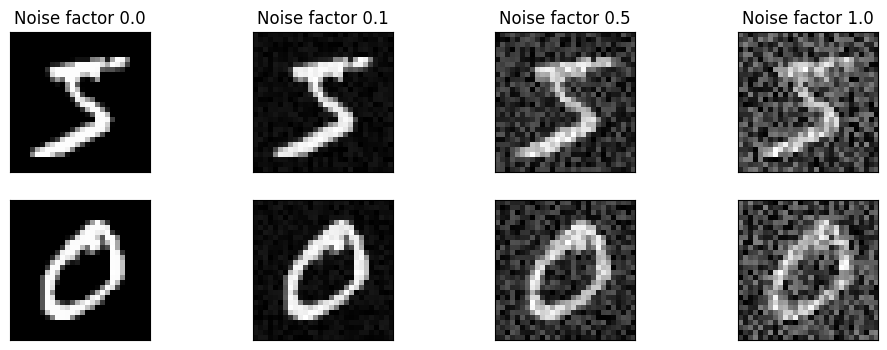

In [35]:

# plot original and noisy images
noise_fcts = [0.0, 0.1, 0.5, 1.0]
fig, axs = plt.subplots(2, len(noise_fcts), figsize=(12, 4))
for i, noise_fct in enumerate(noise_fcts):
    for ax, x in zip(axs[:, i], train_x):
        x = x[0]
# TODO: add Gaussian noise to the image x and scale it by noise_fct
        x_noisy = x + noise_fct * torch.rand_like(x)
        ax.imshow(x_noisy.squeeze().numpy(), cmap='gray')
    axs[0, i].set_title(f'Noise factor {noise_fct}')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

Let's write a simple training loop to train the DAE on the MNIST dataset.

In [36]:
print(f'Original Shape: {train_x.data.shape}')
print(f'ReShape: {train_x.data.view(-1, 28*28).shape}')

Original Shape: torch.Size([60000, 28, 28])
ReShape: torch.Size([60000, 784])


In [37]:

autoencoder = AE()
dae = DAE(autoencoder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dae = dae.to(device)

optimizer = torch.optim.Adam(dae.parameters(), lr=0.001)
criterion = (
# TODO: define the loss function (mean squared error loss)
    nn.MSELoss()
)
for epoch in range(2):
    for i, (images, _) in enumerate(train_x):
        # flatten the images
# TODO: flatten the images
        images = images.view(-1, 28*28).to(device)
        images_recon = dae(images, noise_factor=0.5)
        loss = criterion(images_recon, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.0263
Epoch 2, Loss: 0.0277


In [38]:

summary(dae, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
              ReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 784]         101,136
           Sigmoid-8                  [-1, 784]               0
                AE-9                  [-1, 784]               0
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.83
Estimated Total Size (MB): 0.86
-------------------------------------------

The loss decreased during training, which is a good sign. Let's now visualize the original images, noisy images, and the denoised images.

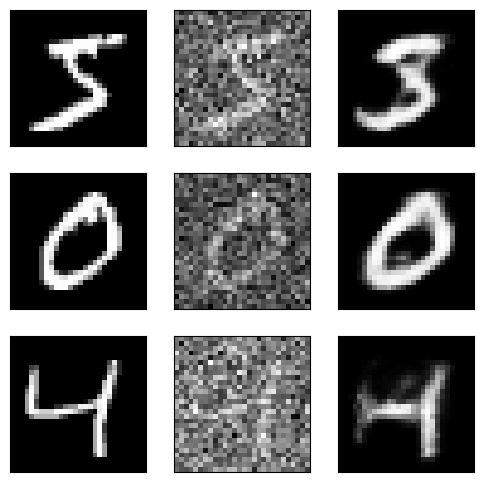

In [39]:

# plot original, noisy and reconstructed images

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i, (images, _) in enumerate(train_x):
    images = images.view(-1, 28*28).to(device)
    noisy_imges = images + 0.5 * torch.randn_like(images)
    recon_images = dae.autoencoder(images)
    for ax, img in zip(axs[i, :], [images, noisy_imges, recon_images]):
        ax.imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    if i == 2:
        break

Let's try to be much more parameter efficient by using a convolutional autoencoder.

In [40]:

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,2,stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = CAE()
dae = DAE(autoencoder)

dae = dae.to(device)

optimizer = torch.optim.Adam(dae.parameters(), lr=0.001)

# Define the loss function and the training loop

criterion = (
    nn.MSELoss()
)

for epoch in range(2):
    for i, (images, _) in enumerate(train_x):
        # note that we do not flatten the images here
        images_recon = dae(images)
        # flatten the images for the loss calculation
        images = images.view(-1, 28*28).to(device)
        images_recon = images_recon.view(-1, 28*28).to(device)
        loss = criterion(images_recon, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [10]:

summary(dae, (1, 28, 28))

In [11]:
# visualize original, noisy and reconstructed images
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i, (images, _) in enumerate(train_x):
    images = images.to(device)
    noisy_imges = images + 0.5 * torch.randn_like(images)
    recon_images = dae.autoencoder(images)
    for ax, img in zip(axs[i, :], [images, noisy_imges, recon_images]):
        ax.imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    if i == 2:
        break

The results are competitive with the fully connected autoencoder, but the convolutional autoencoder is much more parameter efficient (about 7 times less parameters).

## Exercise 2

In this exercise we will get acquainted with the KL divergence for normal distributions.


**(a)** First, let $p(x)=\mathcal{N}(\mu_1,\sigma_1^2)$ and $q(x)=\mathcal{N}(\mu_2,\sigma_2^2)$
and show that

\begin{equation*}
\text{KL}(q||p)
= \mathbb{E}_{x\sim q}\left[\log\frac{q(x)}{p(x)}\right]
=\log\frac{\sigma_1}{\sigma_2}+\frac{\sigma_2^2+(\mu_1-\mu_2)^2}{2\sigma_1^2} -\frac 1 2
\end{equation*}

**(b)** Now, consider a variational autoencoder that takes a vector as input $\textbf{x}$ and
transforms it into a mean vector $\mu(\textbf{x})$ and a variance vector $\sigma(\textbf{x})^2$.
From these, we derive the latent code $\textbf{z}\sim q(\textbf{z})=\mathcal{N}(\mu(\textbf{x}),\text{diag}(\sigma(\textbf{x})^2))$,
i.e. a multivariate Gaussian in $d$ dimensions with a given mean vector and diagonal
covariance matrix. The prior distribution for $\textbf{z}$ is another $d$-dimensional
multivariate Gaussian $p=\mathcal{N}(\textbf{0},\textbf{1})$.

Now show that:

\begin{equation*}
\text{KL}(q||p)= -\frac 1 2 \sum_{i=1}^d \left(1+\log\sigma_i(\textbf{x})^2-\sigma_i(\textbf{x})^2 - \mu_i(\textbf{x})^2 \right)
\end{equation*}

Hint: start by showing that $p$ and $q$ can be factorized into a product of independent
Gaussian components, one for each dimension, then apply the formula for the KL
divergence for the univariate case.



## Exercise 3 (optional)

In this exercise we are going to implement variational autoencoders (VAEs) on the MNIST
dataset.

In [12]:
train_x = MNIST(root='.data', download=True, transform=ToTensor())

In a VAE, the encoder outputs mean and variance of a multivariate Gaussian distribution
of the latent codes. Nothing prevents you from using a more complicated distribution in
the same framework, but this is the usual choice. The expected log likelihood is then
approximated by decoding a single sample from this distribution. Moreover, since we need
the model to be differentiable end-to-end, sampling from the latent codes is
re-formulated via the reparametrization trick.

In the following we define a custom VAE module with a few utility functions that allow
convenient managing of the VAE functionalities.

In [13]:

class VAE(nn.Module):

    # We pass the encoder and decoder over the constructor, which gives us more flexibility.
    def __init__(
            self,
            encoder: nn.Module,
            decoder: nn.Module,
            device: torch.device):
        super().__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device

        # We need a normal distribution for the reparametrization trick
        self.distribution = Normal(0, 1)

    # We define a utility function for sampling the eps with correct shape and device
    def sample_eps(self, sample_shape: Tuple) -> Tensor:
        sampled_eps: Tensor = self.distribution.sample(sample_shape)
        if str(self.device) != 'cpu':
            sampled_eps = sampled_eps.cuda()
        return sampled_eps

    # We output the reconstructed x as well as the latent mu and log variance.
    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        mu, log_var = self.encoder(x)
# TODO: Generate a sample z via the reparametrization trick.
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    # We define an inference method for encoding input tensors.
    def encode(self, x: Tensor) -> Tensor:
        with torch.no_grad():
# TODO: Obtain mu.
        return mu

    # We define an inference method for reconstructing z tensors.
    def reconstruct(self, z: Tensor) -> Tensor:
        with torch.no_grad():
# TODO: Obtain x hat.
        return x_hat


Next, we create our encoder and decoder.
The encoder will have two outputs, which is easily done via the `nn.Module` container.

In [14]:

class Encoder(nn.Module):
    def __init__(self, input_size: int, latent_size: int):
        super().__init__()
        self.net = nn.Sequential(
# TODO: Add a few fully connected layers and activation functions.
# TODO: Choose an appropriate complex model. The output dimension should be 64.
        )

        self.mu = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=latent_size),
            nn.LeakyReLU()
        )

        self.log_var = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=latent_size),
            nn.LeakyReLU()
        )

    def forward(self, x:Tensor) -> Tuple[Tensor, Tensor]:
        x = self.net(x)
        return self.mu(x), self.log_var(x)


class Decoder(nn.Module):
    def __init__(self, output_size: int, latent_size: int):
        super().__init__()
        self.net = nn.Sequential(
# TODO: Add a few fully connected layers and activation functions.
# TODO: Choose an appropriate complex model.
        )

    def forward(self, x:Tensor) -> Tuple[Tensor, Tensor]:
        return self.net(x)


A missing component is a Kullback-Leibler loss function, which we will define
now for two Gaussians:

In [15]:

class KLDivergence:
    def __call__(self, mu: Tensor, log_var: Tensor) -> Tensor:
        return (
# TODO: Compute the KL Loss for a batch of mus and log vars.
# TODO: Use the VAE object to compress/reconstruct x
# TODO: Compute the reconstruction batch_loss per sample
# TODO: Compute the batch KL divergence
# Hint: Divide the obtained KL loss by the number of pixels (for correct KL scale)
# TODO: Compute the total loss
# TODO: Do the backward pass and apply optimizer

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tREC LOSS:\t{:2.3f}\tKL LOSS:\t{:2.3f}'
                      .format(batch_idx, num_train_batches, float(batch_rec_loss), float(batch_kl_loss)), end='\r')

            total_ep_loss += float(total_loss)

        train_losses.append(total_ep_loss / num_train_batches)
        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}'.format(ep, train_losses[-1], end='\r'))

    return train_losses


Finally, we can initialize all our classes and start the training!
We will choose a latent size of 8.

In [16]:
latent_size = 8
epochs = 2
batch_size = 128


encoder = (
# TODO: Create an encoder.
)

decoder = (
# TODO: Create a decoder.
)

vae = (
# TODO: Create a VAE object.
)

optimizer = (
# TODO: Define an optimizer.
)

train_autoencoder(vae, optimizer, train_x, epochs, batch_size)

Let us check the reconstruction of a digit:

In [17]:

def plot_reconstruction_grid(vae: nn.Module, mnist_dataset: MNIST) -> None:
    x_samples = mnist_dataset.data[:100] / 255
    z = vae.encode(x_samples.to(vae.device).view(100, -1))
    x_hat = vae.reconstruct(z).detach().cpu().view(100, 28, 28)

    cur_col = 0
    image_list = []
    for _ in range(4):
        image_list.extend(x_samples[cur_col:cur_col + 25])
        image_list.extend(x_hat[cur_col:cur_col + 25])
        cur_col += 25

    image_batch = torch.stack(image_list).unsqueeze(1)
    image_grid = make_grid(image_batch, nrow=25)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [18]:
plot_reconstruction_grid(vae, train_x)

It is already quite good for only two training epochs!
Now try to remove the division of the KL by 784, train again and visualize the result.

You should see a gray blob that looks a bit like the average of many digits.
This phenomenon is named _mode collapse_, i.e. the distribution of the generator
collapsed to a single mode that covers the entire dataset, instead of (at least)
one mode for every digit. In VAEs, this is typically caused by a KL term that is
very strong at the beginning of training, and dominates the reconstruction loss.
The optimizer will focus most of its efforts to reduce this term, ending up in a poor local minimum.

A popular method to deal with this issue is _KL annealing_.
It consists in training the network without the KL regularizer for some time, then slowly
increasing the weight of the KL. This procedure allows the network to first learn how to
perform good reconstructions, then to adjust the latent code to conform to a Normal
distribution without erasing progress on the reconstruction.

To implement this behaviour, we define a small object that is able to return the
desired KL weight in the respective epoch.

In [19]:
class KLWeightManager:
    """
    Manager to get the desired KL weight.

    Warm up rounds specify the starting epochs until which the KL weight will be zero.
    The annealing rounds describe the duration of the annealing process.
    E.g., warm up is 5 and and there are 10 annealing rounds, then the first 5 epochs
    will have a KL weight of 0 and from epoch 5 to 15 the weight will be annealed to 1.
    """
    def __init__(self, warm_up_rounds: int, annealing_rounds: int):
        self.warm_up = warm_up_rounds
        self.annealing_rounds = annealing_rounds


    def __call__(self, cur_epoch: int) -> float:
        if cur_epoch < self.warm_up:
            return 0.0
        elif cur_epoch >= self.warm_up + self.annealing_rounds:
            return 1.0
        else:
            progress = cur_epoch - self.warm_up
            return progress / self.annealing_rounds


Let's remove the scaling term in the training loop and integrate the `KLWeightManager`:

In [20]:

def train_autoencoder(
        vae: VAE,
        optimizer: Optimizer,
        mnist_dataset: MNIST,
        epochs: int,
        batch_size: int,
) -> List[float]:

    rec_loss = nn.MSELoss(reduction='sum')
    kl_loss = KLDivergence()
    kl_weighting = KLWeightManager(warm_up_rounds=0, annealing_rounds=5)

    train_losses = []

    num_train_batches = ceil(len(mnist_dataset) / batch_size)
    train_loader = DataLoader(mnist_dataset, batch_size, shuffle=True)

    for ep in range(1, epochs + 1):
        total_ep_loss = 0

        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(vae.device).view(x.shape[0], -1)

# TODO: Use the VAE object to compress/reconstruct x
# TODO: Compute the reconstruction batch_loss per sample
# TODO: Compute the batch KL divergence
# TODO: Obtain the KL weight and reweight the KL loss
# TODO: Compute the total loss
# TODO: Do the backward pass and apply optimizer

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tREC LOSS:\t{:2.3f}\tKL LOSS:\t{:2.3f}'
                      .format(batch_idx, num_train_batches, float(batch_rec_loss), float(batch_kl_loss)), end='\r')

            total_ep_loss += float(total_loss)

        train_losses.append(total_ep_loss / num_train_batches)
        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tKL WEIGHT:\t{:.2f}'
              .format(ep, train_losses[-1], kl_weighting(ep), end='\r'))

    return train_losses

In [21]:
latent_size = 8
epochs = 15
batch_size = 128


encoder = (
# TODO: Create an encoder.
)

decoder = (
# TODO: Create a decoder.
)

vae = (
# TODO: Create a VAE object.
)

optimizer = (
# TODO: Define an optimizer.
)

losses = train_autoencoder(vae, optimizer, train_x, epochs, batch_size)

In [22]:
plot_reconstruction_grid(vae, train_x)


It seems like we don't suffer from posterior collaps and our reconstructions look rather
good. It has been shown, that choosing KL weights larger than one can lead to overall
better representations with the downside of worse reconstructions. This framework is
found in literatures as $\beta$-VAE. The correct choice of the KL weight is a difficult
one and depends on the distribution of your dataset and also its dimensionality.

With a VAE we also have a generative model. We could e.g. sample zs from a uniform range
and see what the generator will reconstruct:

In [23]:
rand_z = torch.rand((100, latent_size), device=vae.device)
generated_samples = vae.reconstruct(rand_z).view(100, 1, 28, 28).detach().cpu()

image_grid = make_grid(generated_samples, nrow=25)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

We can also use the generative decoder to smoothly interpolate between random samples:
(Execute the cell a few times to see the interpolation between other random digits)

In [24]:
def interpolate_linear(x: Tensor, y: Tensor, steps: int,) -> Tensor:
    cur_weight = 0.0
    weight_incr = 1 / (steps - 1)

    result = torch.zeros((steps, *x.shape))
    if x.is_cuda:
        result = result.cuda()

    for step in range(steps):
        result[step] = torch.lerp(x, y, cur_weight)
        cur_weight += weight_incr

    return result

x_one = train_x.data[torch.randint(0, 60000, (1,))] / 255.
z_one = vae.encode(x_one.view(1, -1).to(vae.device))

x_two = train_x.data[torch.randint(0, 60000, (1,))] / 255.
z_two = vae.encode(x_two.view(1, -1).to(vae.device))

zs = interpolate_linear(z_one, z_two, steps=20)
x_hats = vae.reconstruct(zs).view(20, 1, 28, 28).detach().cpu()

image_grid = make_grid(x_hats, nrow=20)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
